# lib

In [46]:
%%capture
!apt-get -qq update && apt-get -qq install gcc
!pip install -q basemap basemap-data-hires geopandas descartes momepy pysal

In [25]:
import cudf
import cugraph
import networkx as nx
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.cm as cm
import momepy
import os
from mpl_toolkits.basemap import Basemap
from libpysal import weights
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from geopandas import GeoDataFrame, points_from_xy
import geopandas
import matplotlib
from cfg import *
from utility import *
%matplotlib inline

# global cfg

In [28]:
matplotlib.rc('font', **PLOT_FONT)
plt.switch_backend("cairo")
plt.rc('legend',**{'fontsize':10})

# codebook (columns explanation)

In [29]:
with open("codebook.json", "r") as f: codebook = json.load(f)
codebook

{'movement_bet_tile': {'length_km': 'distance between starting lon/lat and ending lon/lat'}}

# time-series data (scope: Mar 2020 - ?)

In [30]:
mobility_bet_reg = cudf.read_csv("data/movement_bet_admin_reg.csv", date_parser=MOVEMENT_DATE_PARSER, parse_dates=["date_time"]).set_index("date_time").sort_index()
mobility_bet_tiles = cudf.read_csv("data/movement_bet_tiles.csv", date_parser=MOVEMENT_DATE_PARSER, parse_dates=["date_time"]).set_index("date_time").sort_index()
hk_government_policies = cudf.read_csv("data/policies.csv",date_parser=COVID_DATE_PARSER, parse_dates=["date"]).set_index("date").sort_index()
covid_df = cudf.read_csv("data/covid_df.csv", date_parser=COVID_DATE_PARSER, parse_dates=["date"]).set_index("date").sort_index()

# sample data

In [31]:
hk_government_policies.head(1)

,news_title,content,category,relaxation
date,,,,
2020-01-25,No delay in fight against virus: CE,https://www.news.gov.hk/eng/2020/01/20200125/2...,2,<NA>


In [32]:
hk_government_policies.columns

Index(['news_title', 'content', 'category', 'relaxation'], dtype='object')

In [33]:
covid_df.head(1)

,Unnamed: 0,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,5414,ARG,South America,Argentina,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,16.2,27.7,<NA>,5.0,76.67,0.845,<NA>,<NA>,<NA>,<NA>


In [34]:
covid_df.columns

Index(['Unnamed: 0', 'iso_code', 'continent', 'location', 'total_cases',
       'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
   

In [35]:
mobility_bet_reg.head(1)

,GEOMETRY,start_polygon_id,start_polygon_name,end_polygon_id,end_polygon_name,length_km,tile_size,country,level,n_crisis,n_baseline,n_difference,percent_change,is_statistically_significant,z_score,start_lat,start_lon,end_lat,end_lon,geometry
date_time,,,,,,,,,,,,,,,,,,,,
2020-03-01,LINESTRING (114.224853515625 22.31958907278832...,355392,Kwun Tong District,355391,Wong Tai Sin District,3.196177,14,HK,LEVEL3,274.0,351.6,-77.6,-22.007941,0.0,-3.372957,22.315491,114.226018,22.344072,114.204355,<NA>


In [36]:
mobility_bet_tiles.head(1)

,geometry,start_polygon_id,start_polygon_name,end_polygon_id,end_polygon_name,length_km,tile_size,country,level,n_crisis,...,n_difference,percent_change,is_statistically_significant,z_score,start_lat,start_lon,end_lat,end_lon,start_quadkey,end_quadkey
date_time,,,,,,,,,,,,,,,,,,,,,
2020-03-01,LINESTRING (114.114990234375 22.38055513057929...,355394,Tsuen Wan District,355395,Tuen Mun District,13.741262,14,HK,LEVEL3,27.0,...,0.4,1.449275,0.0,0.153393,22.373725,114.089797,22.395483,113.978595,13212223203020,13212223202013


In [37]:
mobility_bet_tiles.columns

Index(['geometry', 'start_polygon_id', 'start_polygon_name', 'end_polygon_id',
       'end_polygon_name', 'length_km', 'tile_size', 'country', 'level',
       'n_crisis', 'n_baseline', 'n_difference', 'percent_change',
       'is_statistically_significant', 'z_score', 'start_lat', 'start_lon',
       'end_lat', 'end_lon', 'start_quadkey', 'end_quadkey'],
      dtype='object')

## Descriptive Analysis

##### Time Series Analysis

##### Graph (Hong Kong)

In [38]:
sample_df = mobility_bet_reg.head(100)[["start_polygon_id", "end_polygon_id"]]

In [39]:
G = nx.MultiDiGraph()
for i in range(len(sample_df)):
    G.add_edge(sample_df.iloc[i]["start_polygon_id"], sample_df.iloc[i]["end_polygon_id"])

Basemap approach

In [22]:
m = Basemap(**HONG_KONG_BASEMAP_CFG)

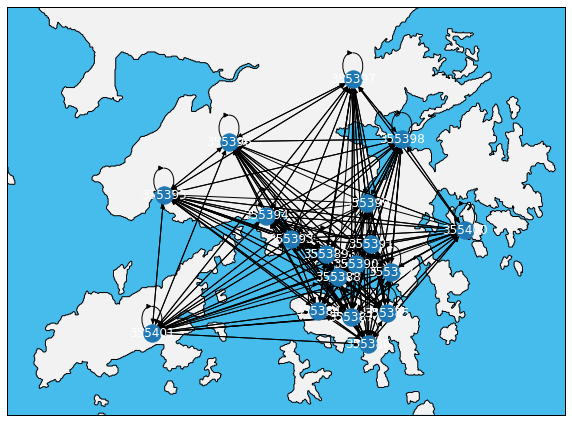

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
nx.draw_networkx(G, BASEMAP_MOVEMENT_POLYGON_LAT_LON, font_color="white")
plt.show()

Geopandas approach
https://networkx.org/documentation/stable/auto_examples/geospatial/plot_polygons.html

In [40]:
hong_kong = GeoDataFrame.from_file('assets/traffic-cameras-geopandas/Hong_Kong_18_Districts/')

In [41]:
centroids = np.column_stack((hong_kong.centroid.x, hong_kong.centroid.y))

/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [42]:
queen = weights.Queen.from_dataframe(hong_kong)

/opt/conda/envs/rapids/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 4, 6, 9, 13, 16.
  warnings.warn(message)


In [43]:
graph = queen.to_networkx()

In [44]:
positions = dict(zip(graph.nodes, centroids))

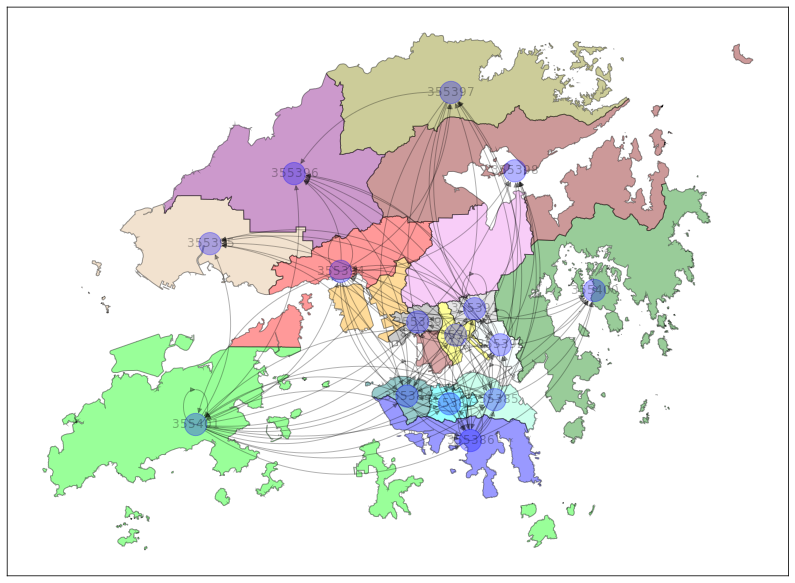

In [45]:
fig, ax = plt.subplots(figsize=(14, 14))
hong_kong.plot(color=["silver", "orange",  "grey",  "brown", "yellow", "azure",  
                      "green", "maroon", "violet", "olive", "teal", "aqua",  
                      "aquamarine", "burlywood", "purple",  "red", "lime", "blue"], 
               edgecolor='black', alpha=0.4, ax=ax)
new_pos = {}
for k, v in positions.items():
    new_pos[QUEEN_MOVEMENT_MAPPER[k]] = v
nx.draw_networkx(G, new_pos, with_labels=True, alpha=0.3, node_color="blue", edge_color="black", connectionstyle='arc3, rad = 0.3', node_size=500)
plt.show()

Graph Tool implementation

## Inferential Analysis